In [172]:
from pymorphy2 import MorphAnalyzer
import pandas as pd
import numpy as np

In [173]:
df = pd.read_csv('dataset.csv')
df.head()

,uu_usl_name,CLASS_ID,SERVICE_CLASS_CONFIRMED,CNT_DIST_USL_BY_CLASS,CNT_NUM_USL
0,АМБУЛАТОРНАЯ ПОМОЩЬ,1000,NaN,12614,812414
1,АМБУЛАТОРНАЯ ПОМОЩЬ,1292,NaN,777,812414
2,КОНСУЛЬТАТИВНО-ДИАГНОСТИЧЕСКАЯ ПОМОЩЬ,1000,NaN,12614,740580
3,Сбербанк Премьер,3200,1.0,3974,489254
4,Сбербанк Премьер,8350,1.0,104,489254


In [174]:
def prepare_Xy():
    df = pd.read_csv('dataset.csv')
    df = df.query('CLASS_ID != 9000')
    X = df['uu_usl_name']
    y = df['CLASS_ID']
    return X,y
X, y = prepare_Xy()



In [175]:
import pymorphy2
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
russian_stopwords = stopwords.words("russian")

morph = pymorphy2.MorphAnalyzer()
X = X.apply(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in word_tokenize(x) if word not in russian_stopwords]))

In [176]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cv = TfidfVectorizer()
tX = cv.fit_transform(X)

In [177]:
tX.shape

(81431, 15633)

In [178]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(tX,y,test_size=0.1)

In [179]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=20,
    max_depth=200,
    random_state=1,
    min_samples_split=10,
    min_samples_leaf=10,
    max_features=int(np.sqrt(tX.shape[1])),
)


In [180]:
# from sklearn.naive_bayes import MultinomialNB
# model = MultinomialNB(
#     alpha=0.1,
#     fit_prior=True,
#     class_prior=None,
# )

In [181]:
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=200, max_features=125, min_samples_leaf=10,
                       min_samples_split=10, n_estimators=20, random_state=1)

In [182]:
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
print(accuracy_score(y_test, pred))

0.45898821218074654


In [183]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        1000       0.16      0.23      0.19      1282
        1001       0.00      0.00      0.00        68
        1002       0.00      0.00      0.00         7
        1004       0.00      0.00      0.00         1
        1010       0.00      0.00      0.00         8
        1020       0.00      0.00      0.00         2
        1050       0.00      0.00      0.00         1
        1101       0.56      0.77      0.65       136
        1111       0.00      0.00      0.00        26
        1121       0.00      0.00      0.00         8
        1131       0.00      0.00      0.00         3
        1132       0.00      0.00      0.00         3
        1201       0.68      0.65      0.66        85
        1211       0.63      0.96      0.76        70
        1212       0.00      0.00      0.00         1
        1221       0.68      0.90      0.78        73
        1222       0.00      0.00      0.00         1
        1231       0.70    

C:\Users\user\PycharmProjects\NLP\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\PycharmProjects\NLP\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\PycharmProjects\NLP\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

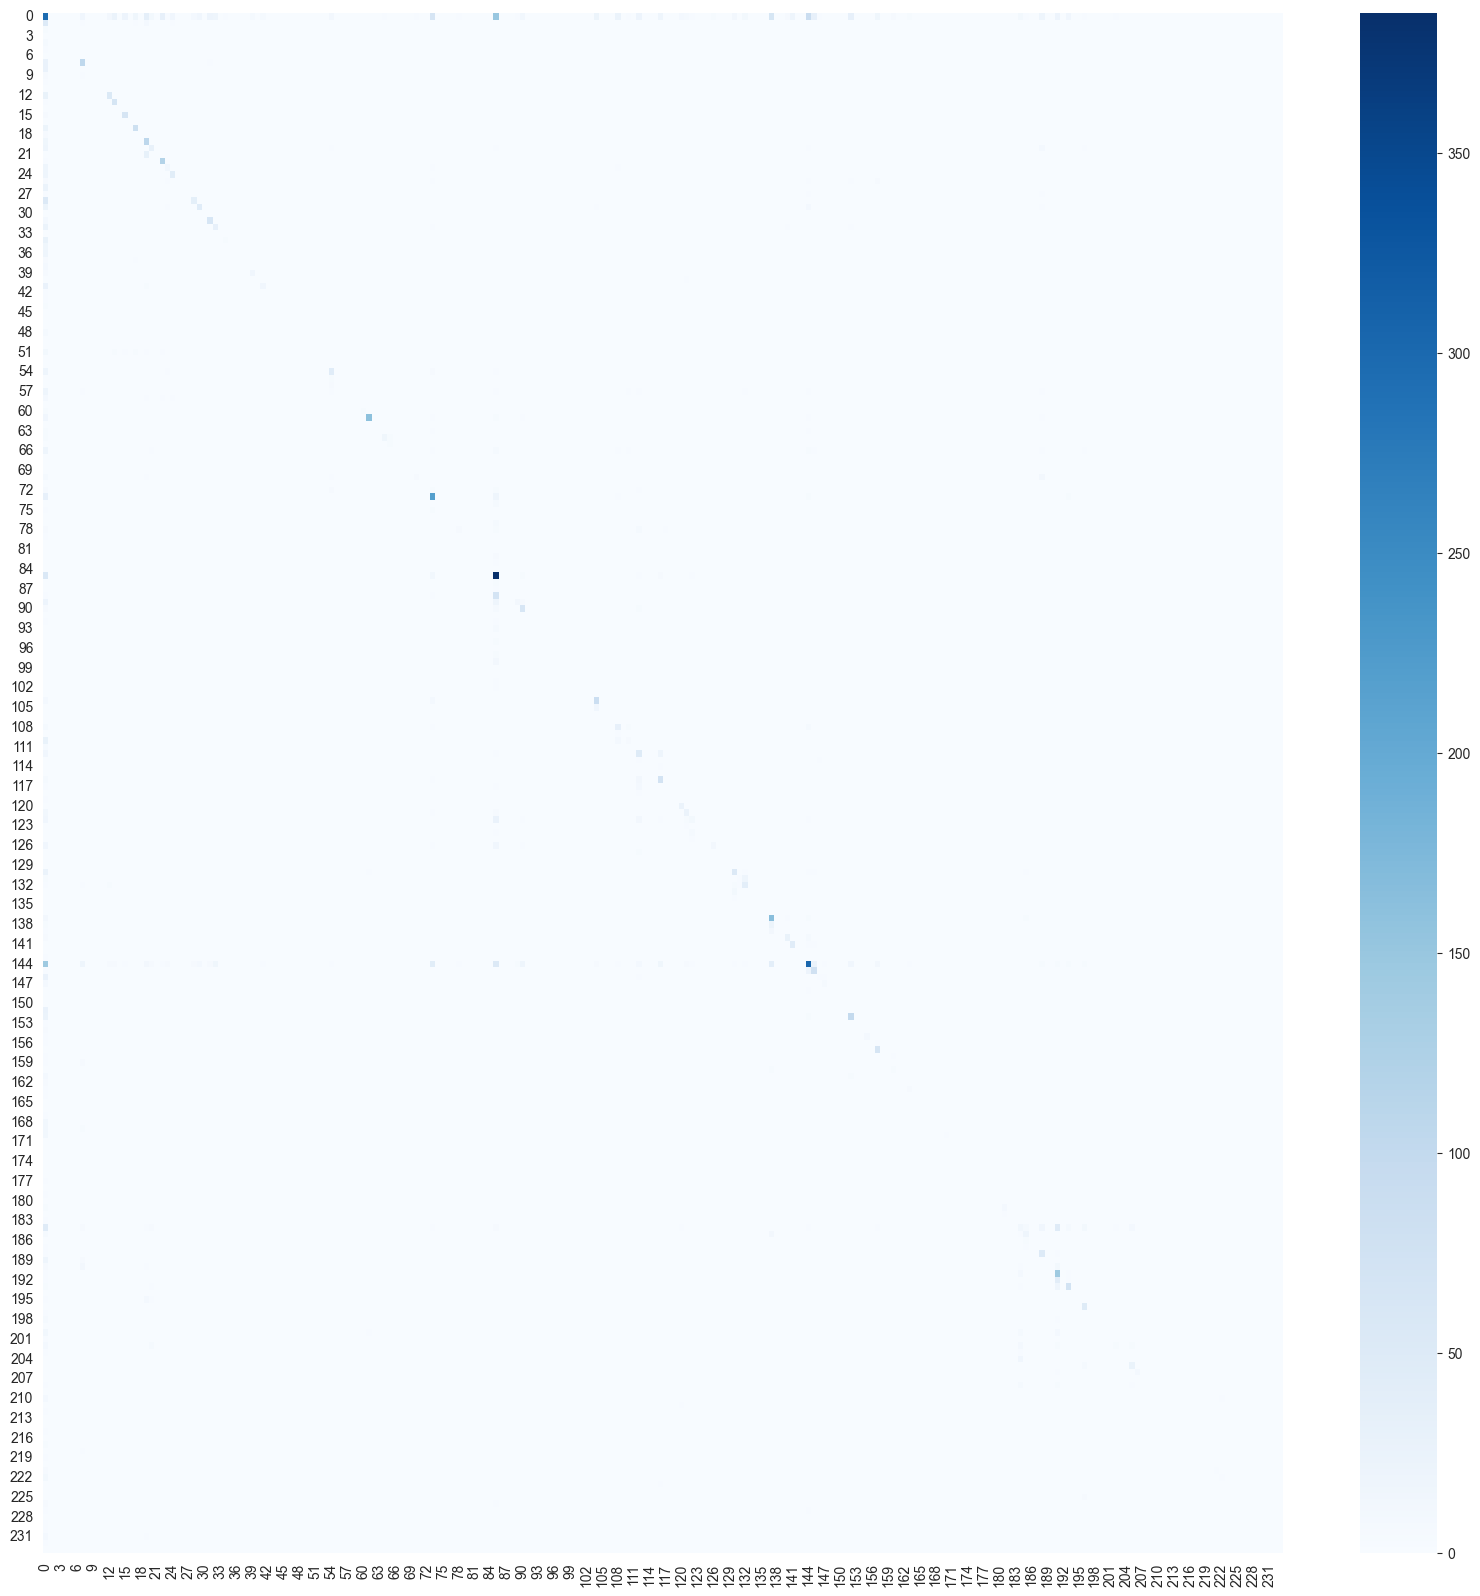

In [184]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
sns.heatmap(confusion_matrix(y_test, pred), annot=False, fmt='d', cmap='Blues')

In [185]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=model.classes_)
pred_bin = model.predict_proba(X_test)
roc_auc_score(y_test_bin, pred_bin, average='micro')

0.9894442346574761

C:\Users\user\PycharmProjects\NLP\venv\lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\user\PycharmProjects\NLP\venv\lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\user\PycharmProjects\NLP\venv\lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\user\PycharmProjects\NLP\venv\lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\user\PycharmProjects\NLP\venv\lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be mean

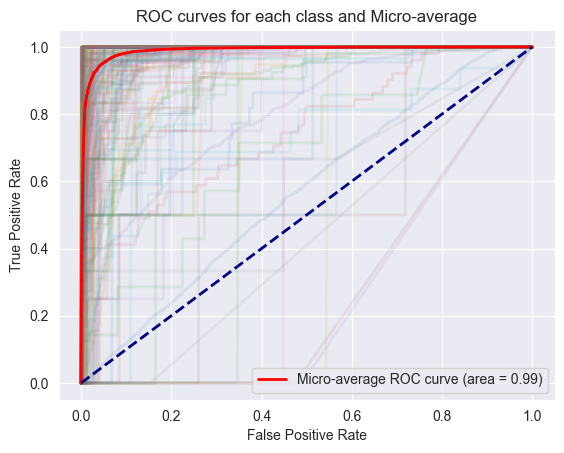

In [186]:
# draw average roc auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, alpha=0.1)

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"], )

plt.plot(fpr["micro"], tpr["micro"], color='red', lw=2, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for each class and Micro-average')
plt.legend(loc="lower right")
plt.show()


In [187]:
from joblib import dump, load
dump(model, 'simple_vectorized_model.joblib')
dump(cv, 'simple_vectorized_cv.joblib')

['simple_vectorized_cv.joblib']